In [13]:
# In this notebook we explain and compare the performance of the frequency localized and time localized inference algorithms, providing with formulas
# the experiments/error_comparison.py script

import numpy as np
from fourier import compute_fourier_coeff
from kernels import  dirichlet_kernel
from fourier_inference import  compute_prediction

import matplotlib.pyplot as plt

In [14]:
seed = 42  # or any integer of choice
rng = np.random.default_rng(seed)

In [15]:
# Number of input functions
num_samples = 50

grid_size = 2**11 # grid points

t_left = -40
t_right = 40   # time interval

time_span = t_right - t_left

time_array = np.linspace(t_left,t_right,grid_size)
noise = .01 # noise level in the data


In [16]:
import numpy as np

def heat_kernel(x, t):
    """
    Compute the heat kernel (Green's function) for the heat equation.

    The heat kernel is given by:
        G(x, t) = exp(-x^2 / (4t)) / sqrt(4πt)
    
    Parameters:
    -----------
    x : float or np.ndarray
        The spatial coordinate(s).
    t : float
        The time variable (must be positive).
    
    Returns:
    --------
    float or np.ndarray
        The value of the heat kernel evaluated at x and t.
    """
    if t <= 0:
        raise ValueError("Time 't' must be positive.")
    
    return np.exp(-x**2 / (4 * t)) / np.sqrt(4 * np.pi * t)


In [17]:
t_fix =1

Text(0.5, 1.0, 'Heat kernel (target) function')

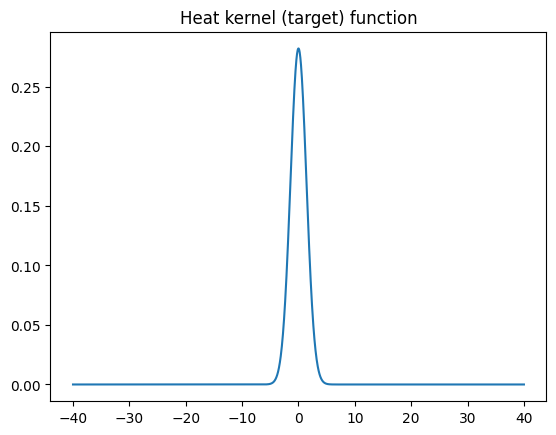

In [18]:
target = heat_kernel(time_array, t_fix)
target_coeff = compute_fourier_coeff(target, time_span)
#plot the target function
plt.plot(time_array, target, label='Target function')
plt.title('Heat kernel (target) function')

In [19]:
#Choose a kernel 

# kernel_decay =  2 # decay rate of the  complex exponential kernel   #1.01
# kernel_coeff = get_fourier_coeffs(kernel_decay, time_span, grid_size, c0=1/2, scale=3/(2*np.pi**2))

kernel= dirichlet_kernel(time_array, 4)
kernel_coeff = compute_fourier_coeff(kernel, time_span)


#Dirichlet kernel or other kernel??

In [20]:
def generate_samples_for_heat(n_samples, time_array, delta, seed=None):
    """
    Generates time-localized samples using a normal distribution and creates a time-localized array.
    
    Parameters
    ----------
    n_samples : int
        Number of samples to generate.
    time_array : numpy.ndarray
        Array of time points where the samples will be localized.
    delta : float
        The localization factor.
    seed : int or None, optional
        Seed for the random number generator. If an integer is provided, the random numbers 
        will be reproducible; if None, the random numbers will be different on each call.
    
    Returns
    -------
    numpy.ndarray
        Time-localized sample matrix of shape (len(time_array), n_samples)
    """
    # Create a random number generator with the given seed (or use system entropy if seed is None)
    rng = np.random.default_rng(seed)
    
    # Generate random times using the RNG
    random_times = rng.normal(0, 0.16, n_samples)
    
    # Create the time-localized sample matrix.
    # For each random time 't', mark entries in time_array that are within ±delta of 't'.
    X = np.array([
        np.where(((time_array - t) <= delta) & ((time_array - t) >= -delta), 1, 0)
        for t in random_times
    ]).T / (2 * delta)
    
    return X

In [21]:
# Input functions 
delta = .0005
samples = generate_samples_for_heat(num_samples, time_array, delta, seed)
r_time_loc = 1 / 2
b_time_loc = 2

In [22]:
# run inference for time-localized signals
heat_prediction_coeff, heat_prediction_tie = compute_prediction(
    num_samples=num_samples,
    time_array=time_array,
    time_span=time_span,
    kernel_coeff=kernel_coeff,
    target_coeff=target_coeff,
    noise=noise,
    r=r_time_loc,
    b = b_time_loc,
    const = 1e-4,
    X= samples
)

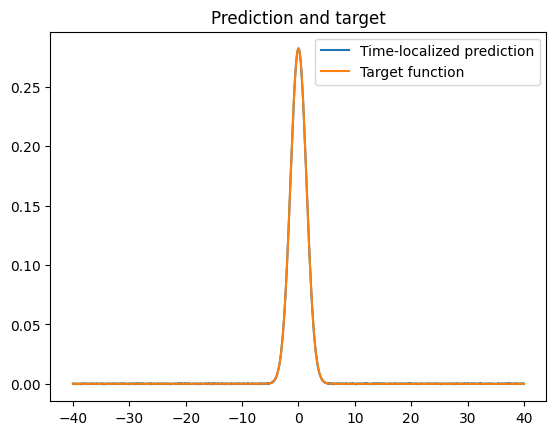

In [23]:
plt.plot(time_array, heat_prediction_tie, label='Time-localized prediction')
plt.plot(time_array, target, label='Target function')
plt.title('Prediction and target')
plt.legend()